In [40]:
# Author: Jaehun Kim
# Email: rlawogns1204@unist.ac.kr
# Affiliation: UNIST BME BCILAB
# Date: 2023-06-08
#
# This code implements a tactile information processing model using a spiking
# neural network (SNN). It simulates the processing of tactile information from
# mechanoreceptors in the skin through primary afferent fibers (PA), cuneate nucleus
# neurons (PN and IN), and ultimately, somatosensory cortex neurons. The model
# incorporates lateral inhibition and various receptive field properties to
# represent a realistic processing of touch stimuli.

# with DIGIT-sensor
# pip install torch==1.8.1+cu101 torchvision==0.9.1+cu101 torchaudio==0.8.1 -f https://download.pytorch.org/whl/torch_stable.html
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import scipy.io
import time
import numpy as np
from PIL import Image
import io
import datetime
import cv2


from Function.snn_receptive_field import *
from Function.SNNModule import *
from Function.plot_SNN import *
from Function.SNN import *
from Function.Stimulation_GPU import *
from Function.snn_receptive_field_weights import *


from line_profiler import LineProfiler

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
# Check if GPU is available and print the CUDA version
print(f"GPU available: {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")
# Enable GPU support if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Set the device to 'cpu'
device = 'cpu'
print(f"Using device: {device}")
# Start of the SNN (Spiking Neural Network) code

GPU available: True
CUDA version: 10.1
Using device: cpu


In [26]:
# Set sensor dimensions (height and width in millimeters)
sensor_h, sensor_w = 19, 16
# Set pixel dimensions (number of pixels in height and width)
# pixel_h, pixel_w = 320, 240///
pixel_h, pixel_w = 64,48
# Set image frames per second (FPS) of tactile sensor
image_FPS = 60

In [39]:
R = ReceptiveFieldWeights(pixel_h, pixel_w, device)

noise_std_val = 0
sa_layer = IzhikevichLayer(0.02, 0.2, -65, 8, len(R.sa_rf),v_thres=30, a_decay=1.01, noise_std = noise_std_val, device=device)

torch.Size([88, 3072])
sa_rf shape: torch.Size([88, 3072]) with height = 11 with width = 8
ra_rf shape: torch.Size([130, 3072]) with height = 13 with width = 10
sa_cn_pn_rf shape:  torch.Size([54, 88]) sa_cn_pn_step_height: 9 sa_cn_pn_step_width: 6
sa_cn_in_RF shape:  torch.Size([54, 88]) sa_cn_in_step_height: 9 sa_cn_in_step_width: 6
ra_cn_pn_rf shape:  torch.Size([88, 130]) ra_cn_pn_step_height: 11 ra_cn_pn_step_width: 8
ra_cn_in_RF shape:  torch.Size([88, 130]) ra_cn_in_step_height: 11 ra_cn_in_step_width: 8
sa_intopn_RF shape:  torch.Size([54, 54])
ra_intopn_RF shape:  torch.Size([88, 88])
cn_pn_sa_rf shape:  torch.Size([112, 54]) cn_pn_sa_rf_step_height: 7 cn_pn_sa_rf_step_width: 4
cn_in_sa_rf shape:  torch.Size([112, 54]) cn_in_sa_rf_step_height: 7 cn_in_sa_rf_step_width: 4
cn_pn_ra_rf shape:  torch.Size([112, 88]) cn_pn_ra_rf_step_height: 7 cn_pn_ra_rf_step_width: 4
cn_in_ra_rf shape:  torch.Size([112, 88]) cn_in_ra_rf_step_height: 7 cn_in_ra_rf_step_width: 4
cn_intopn_RF shape:

In [21]:
noise_std_val = 0

# Create Izhikevich layers
sa_layer = IzhikevichLayer(0.02, 0.2, -65, 8, len(R.sa_rf),v_thres=30, a_decay=1.01, noise_std = noise_std_val, device=device)
sa_cn_in_layer = IzhikevichLayer(0.1, 0.2, -65, 6, len(sa_cn_in_RF),v_thres=30, a_decay=1, noise_std = noise_std_val, device=device)
sa_cn_pn_layer = IzhikevichLayer(0.1, 0.2, -65, 6, len(sa_cn_pn_rf),v_thres=30, a_decay=1, noise_std = noise_std_val, device=device)

ra_layer = IzhikevichLayer(0.02, 0.2, -65, 8, len(ra_rf),v_thres=30, a_decay=1, noise_std = noise_std_val,device=device)
ra_cn_in_layer = IzhikevichLayer(0.1, 0.2, -65, 6, len(ra_cn_in_RF),v_thres=30, a_decay=1, noise_std=noise_std_val, device=device)
ra_cn_pn_layer = IzhikevichLayer(0.1, 0.2, -65, 6, len(ra_cn_pn_rf),v_thres=30, a_decay=1,noise_std = noise_std_val, device=device)

sa_layers = [sa_layer, sa_cn_in_layer, sa_cn_pn_layer]
ra_layers = [ra_layer, ra_cn_in_layer, ra_cn_pn_layer]

sa_synapse = Synapse(sa_rf.to(device), device=device)
sa_cn_in_synapse = Synapse(sa_cn_in_RF.to(device), delays=sa_cn_SD, device=device)
sa_cn_pn_synapse = Synapse(sa_cn_pn_rf.to(device), delays=sa_cn_SD, device=device)
sa_cn_intopn_synapse = Synapse(sa_intopn_RF.to(device), delays = sa_intopn_DN, tau_psp = 10, device = device)

ra_synapse = Synapse(ra_rf.to(device), device=device)
ra_cn_in_synapse = Synapse(ra_cn_in_RF.to(device), delays=ra_cn_SD, device=device)
ra_cn_pn_synapse = Synapse(ra_cn_pn_rf.to(device), delays=ra_cn_SD, device=device)
ra_cn_intopn_synapse = Synapse(ra_intopn_RF.to(device), delays = ra_intopn_DN, tau_psp = 10, device = device)

sa_synapses = [sa_synapse, sa_cn_in_synapse, sa_cn_pn_synapse, sa_cn_intopn_synapse]
ra_synapses = [ra_synapse, ra_cn_in_synapse, ra_cn_pn_synapse, ra_cn_intopn_synapse]

# 3rd layer 
cn_in_layer = IzhikevichLayer(0.1, 0.2, -65, 6, len(cn_in_sa_rf), v_thres=30, a_decay=1, noise_std = noise_std_val, device=device)
cn_pn_layer = IzhikevichLayer(0.1, 0.2, -65, 6, len(cn_pn_sa_rf),v_thres=30, a_decay=1, noise_std = noise_std_val, device=device)

cn_in_sa_synapse = Synapse(cn_in_sa_rf.to(device), delays=cn_sa_SD, device=device)
cn_pn_sa_synapse = Synapse(cn_pn_sa_rf.to(device), delays=cn_sa_SD, device=device)
cn_in_ra_synapse = Synapse(cn_in_ra_rf.to(device), delays=cn_ra_SD, device=device)
cn_pn_ra_synapse = Synapse(cn_pn_ra_rf.to(device), delays=cn_ra_SD, device=device)

cn_intopn_synapse = Synapse(cn_intopn_RF.to(device), delays = cn_intopn_DN, tau_psp = 10, device = device)

cn_layers = [cn_in_layer, cn_pn_layer]
cn_synapses = [cn_in_sa_synapse, cn_pn_sa_synapse, cn_in_ra_synapse, cn_pn_ra_synapse, cn_intopn_synapse]

torch.Size([88, 3072])
sa_rf shape: torch.Size([88, 3072]) with height = 11 with width = 8
ra_rf shape: torch.Size([130, 3072]) with height = 13 with width = 10
sa_cn_pn_rf shape:  torch.Size([54, 88]) sa_cn_pn_step_height: 9 sa_cn_pn_step_width: 6
sa_cn_in_RF shape:  torch.Size([54, 88]) sa_cn_in_step_height: 9 sa_cn_in_step_width: 6
ra_cn_pn_rf shape:  torch.Size([88, 130]) ra_cn_pn_step_height: 11 ra_cn_pn_step_width: 8
ra_cn_in_RF shape:  torch.Size([88, 130]) ra_cn_in_step_height: 11 ra_cn_in_step_width: 8
sa_intopn_RF shape:  torch.Size([54, 54])
ra_intopn_RF shape:  torch.Size([88, 88])
cn_pn_sa_rf shape:  torch.Size([112, 54]) cn_pn_sa_rf_step_height: 7 cn_pn_sa_rf_step_width: 4
cn_in_sa_rf shape:  torch.Size([112, 54]) cn_in_sa_rf_step_height: 7 cn_in_sa_rf_step_width: 4
cn_pn_ra_rf shape:  torch.Size([112, 88]) cn_pn_ra_rf_step_height: 7 cn_pn_ra_rf_step_width: 4
cn_in_ra_rf shape:  torch.Size([112, 88]) cn_in_ra_rf_step_height: 7 cn_in_ra_rf_step_width: 4
cn_intopn_RF shape:

FPS: 60.0
Average Time per Frame: 0.010174173514048259 sec
torch.Size([64, 48, 600])
Mean: 102.44781494140625
Standard Deviation: 28.157129287719727
Variance: 792.823974609375
start feedforward with None
torch.Size([64, 48, 600])


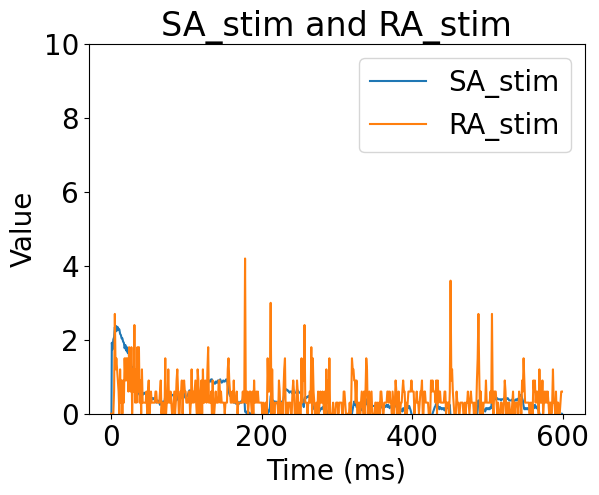

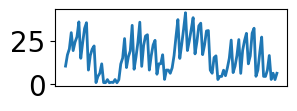

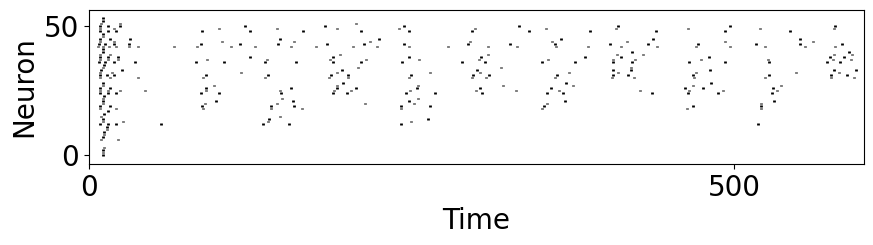

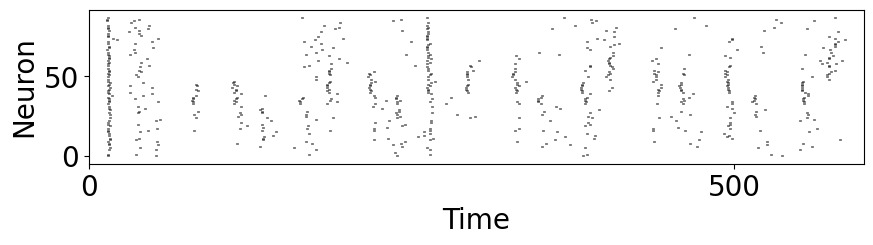

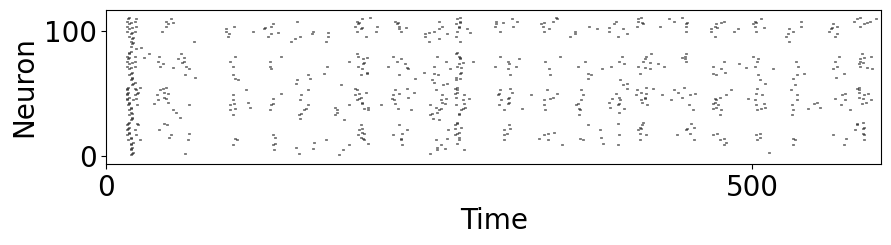

In [86]:
cap = cv2.VideoCapture(0)

desired_width = 320
desired_height = 240
cap.set(cv2.CAP_PROP_FRAME_WIDTH, desired_width)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, desired_height)

cap.set(cv2.CAP_PROP_FPS, 60)
fps = cap.get(cv2.CAP_PROP_FPS)
print(f"FPS: {fps}")

frames = []  # Frame을 저장할 리스트
frame_count = 0  # 캡처한 Frame 수
total_time = 0  # 측정 시간의 합계

while True: 
    startT = time.time()

    ret, frame = cap.read() 

    if not ret or frame_count == 600:  # 캡처가 실패하거나 600프레임을 캡처하면 종료
        break

    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)  # Frame을 Grayscale로 변경
    # sobel = cv2.Sobel(gray_frame, cv2.CV_8U, 1, 0, 3) *10
    # Frame을 상하로 뒤집고, 반시계 방향으로 90도 회전
    flipped_frame = cv2.flip(gray_frame, 0)
    rotated_frame = cv2.rotate(flipped_frame, cv2.ROTATE_90_COUNTERCLOCKWISE)
    resized_frame = cv2.resize(rotated_frame, (48, 64))  # Frame 크기를 64x48로 변경

    frames.append(resized_frame)  # 변경된 Frame을 리스트에 추가
    frame_count += 1  # Frame 수 증가

    cv2.imshow('frame', resized_frame)
    endT = time.time()
    total_time += (endT - startT)  # 측정 시간 누적
    # 10ms 기다리고 다음 프레임으로 전환, Esc누르면 while 강제 종료
    if cv2.waitKey(1) == 27:
        break

cap.release() 
cv2.destroyAllWindows()

avg_time = total_time / frame_count if frame_count else 0  # 평균 실행 시간 계산
print(f"Average Time per Frame: {avg_time} sec")  # 평균 실행 시간 출력

# Convert all frames to PyTorch tensors and stack them along the third dimension
stimulation = torch.stack([torch.from_numpy(frame) for frame in frames], dim=2).float()

print(stimulation.shape)

mean_value = stimulation.mean().item()
std_dev = stimulation.std().item()
variance = stimulation.var().item()

print(f"Mean: {mean_value}")
print(f"Standard Deviation: {std_dev}")
print(f"Variance: {variance}")

plt.rcParams['font.size'] = 20
fig_size = (10, 2)
line_lengths = 0.6

S = SNNModel([SA_layers, RA_layers, CN_layers], [SA_synapses, RA_synapses, CN_synapses], rf_sizes=rf_sizes, device=device)
S.feedforward(stimulation*0.03)

mean_firing_rates = plot_SNN(S)
plot_spike_times(S.SA_spike_times[2], size=fig_size, colors='k', line_lengths=line_lengths)
plot_spike_times(S.RA_spike_times[2], size=fig_size, colors='k', line_lengths=line_lengths)
plot_spike_times(S.CN_spike_times[1], size=fig_size, colors='k', line_lengths=line_lengths)

recording_stimulation(stimulation)